In [0]:
!rm -r "/content/lfw"
!wget "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
!tar xvzf /content/lfw.tgz


In [0]:
#@title Este bloque requiere del archivo tools.zip en la raiz de Colab
photos="/content/images"
original="/content/images/original"
cut="/content/images/cut"
combined="/content/images/combined"
!mkdir "/content/images"
!mkdir "/content/images/original"
!mkdir "/content/images/cut"

!mkdir "/content/images/combined"
!mkdir "/content/images/tools"

#!unzip "/content/drive/My Drive/neural/deep-learning-face-detection.zip" -d "/content/images/tools"
#!unzip "/content/drive/My Drive/neural/neural_feature_follower.zip" -d "/content/images/tools"



!unzip "/content/tools.zip" -d "/content/images/tools"
#!unzip "/content/drive/My Drive/neural_feature_follower.zip" -d "/content/images/tools"
#!unzip "/content/dataset.zip" -d "/content/images/original"

In [0]:
import os
import sys
from django.http import request
from os import rename
import requests
import shutil
maleFolder = "/content/male"
!rm -r "/content/male"
!rm -r "/content/female"
femaleFolder = "/content/female"
!mkdir "/content/female"
!mkdir "/content/male"


maxf=2000


def get_dataset():
    fileList = []
    fileSize = 0
    folderCount = 0
    rootdir = "/content/lfw"
    
    count = 0
    tmp = ""

    for root, subFolders, files in os.walk(rootdir):
        folderCount += len(subFolders)
        for file in files:
            f = os.path.join(root,file)
            fileSize = fileSize + os.path.getsize(f)
            fileSplit = file.split("_")
            fileList.append(f)
            count += 1

            if count == 1:
                result = requests.get("http://api.genderize.io?name=%s" % fileSplit[0])
                result = result.json()
                tmp = fileSplit[0]
            elif tmp != fileSplit[0]:
                result = requests.get("http://api.genderize.io?name=%s" % fileSplit[0])
                result = result.json()
                tmp = fileSplit[0]
            else:
                tmp = fileSplit[0]

            
            if float(result['probability']) > 0.9:
              if result['gender'] == 'male':
                shutil.copyfile(f,maleFolder+"/"+str(count)+".jpg")
              elif result['gender'] == 'female':
                shutil.copyfile(f,femaleFolder+"/"+str(count)+".jpg")
            print("Copied: "+str(count))
            if(count==maxf):
              break
            



get_dataset()

In [0]:
import os
import glob
from shutil import copyfile
!rm -r "/content/images/original"
!mkdir "/content/images/original"
i=0
for filename in glob.glob('/content/male/*.jpg'):
    i+=1
    print(i)
    copyfile(filename,original+"/"+str(i)+".jpg")

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob


path_model="/content/images/tools/deploy.prototxt.txt"
path_weigths="/content/images/tools/res10_300x300_ssd_iter_140000.caffemodel"



net = cv2.dnn.readNetFromCaffe(path_model, path_weigths)
path_image=original+"/"


def get_face(path):
  image = cv2.imread(path)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  ti_face=False
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      ti_face=True
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      distanceX=abs(endX-startX)
      distanceY=abs(endY-startY)
      startY-=distanceY*0.2
      endY+=distanceY*0.1
      endX+=distanceX*0.5
      startX-=distanceX*0.5
      startX=int(max(startX,0))
      startY=int(max(startY,0))
      endX=int(min(endX,w))
      endY=int(min(endY,h))
      print(startX,endX,startY,endY)
      text = "{:.2f}%".format(confidence * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      image=image[startY:endY,startX:endX,:]
    if (i > -1) and confidence>0.5:
      break  
  return image,ti_face  


num_p=1000  
!rm -r  "/content/images/cut" 
!mkdir "/content/images/cut"  
if(True):
  for i,filename in enumerate(glob.glob(path_image+"*.jpg")):
    path=filename
    print("Processing image "+path)
    image,ret=get_face(path)
    if(i==num_p):
      break
    if(ret):
      cv2.imwrite(cut+"/"+str(i)+".jpg",image)
      print("Face Generated")
    else:
      print("Error generating image")



In [0]:
import cv2
def get_skecth(img_rgb):
    img_rgb=cv2.resize(img_rgb,(500,500))
    img_gray = 255-cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (101,101),0,0)
    img_blend = cv2.divide(img_blur, img_gray, scale=256)
    kernel1 = np.ones((3,3), np.uint8)       
    img_blur = cv2.erode(img_blend, kernel1, iterations=10)
    can=cv2.Canny(img_blend,50,100)
    im1=cv2.bitwise_and(255*np.ones((500,500,3)),255*np.ones((500,500,3)),mask=can)
    imt=cv2.dilate(im1,np.ones((7,7), np.uint8))
    a,val=paint(img_rgb,255-imt)
    
    
    
    return a,val
  
  
  
  
  
import dlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/images/tools/neural_feature_follower/NN3W.dat")
def paint(im,dest):
  image=im
  image = cv2.resize(image,(500,500))
  dest=dest
  image2=image[:,:,:].copy()
  hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  val=False
  rects = detector(gray, 1)
  for (i, rect) in enumerate(rects):
        val=True
        if(i>0):
          break  
        features = predictor(gray, rect)
        face=[]
        face=[]
        eye1=[]
        eye2=[]
        eye1u=[]
        eye2u=[]
        nose=[]
        mouth=[]
        mouth2=[]
        factor=0.4
        distance=(rect.top()-rect.bottom())*factor
        factor2=0.2
        distance2=(rect.right()-rect.left())*factor2
        
        for b in range(68):
            p1=[features.part(b).x,features.part(b).y]
            if(b<17):
              face.append(p1)
            if(b>=22 and b<=26):
              eye1u.append(p1) 
            if(b>=17 and b<=21):
              eye2u.append(p1)   
            if(b>=36 and b<=41):
              eye1.append(p1)
            if(b>=27 and b<=35):
              nose.append(p1)  
            if(b>=42 and b<=47):
              eye2.append(p1)
            if(b>=48 and b<=59):
              mouth.append(p1) 
            if(b>=60 and b<=68):
              mouth2.append(p1)
              
            #cv.line(image,tuple(p1),tuple(p2),(0,255,0),3)
            #cv.circle(image, (features.part(b).x,features.part(b).y), 6, (0, 255, 0), -1)  
         
        
        cv2.polylines(dest,[np.array(face)],False,(0,0,255),6)
        cv2.drawContours(dest,[np.array(eye1)],-1,(0,255,0),-1)
        cv2.drawContours(dest,[np.array(eye2)],-1,(0,255,0),-1)
        
        
        #cv2.drawContours(dest,[np.array(eye1)],-1,(255,0,0),6)
        #cv2.drawContours(dest,[np.array(eye2)],-1,(255,0,255),6)
        
        
        cv2.drawContours(dest,[np.array(nose)],-1,(255,0,0),-1)
        cv2.drawContours(dest,[np.array(mouth)],-1,(255,0,255),-1)
        cv2.drawContours(dest,[np.array(eye1u)],-1,(0,255,255),-1)
        cv2.drawContours(dest,[np.array(eye2u)],-1,(0,255,255),-1)
        cv2.drawContours(dest,[np.array(mouth2)],-1,(0,0,0),-1)
             
        
        return dest,val

  
  
  
  
imga=cv2.imread("/content/images/cut/112.jpg")

d,val=get_skecth(imga)
plt.imshow(d)



  


In [0]:
!rm -r "/content/images/combined"
!mkdir "/content/images/combined"
!rm -r "/content/images/combinedval"
!mkdir "/content/images/combinedval"
valf="/content/images/combinedval"
import glob
import cv2
path=cut
print(cut)
size=(256,256)
i=0
for filename in glob.glob(path+"/*.jpg"):
  if(i>1000):
    break
  img=cv2.imread(filename)
  try:
    print(filename)
    im1,val=get_skecth(img)
    print(im1.shape)
    if(val and i<700):
      cv2.imwrite(combined+"/"+str(i)+".jpg",np.concatenate((cv2.resize(img,size),cv2.resize(im1,size)),axis=1))
      i+=1
      print(">>Train images: "+str(i))
    if(val and i>=700):
      cv2.imwrite(valf+"/"+str(i-700)+".jpg",np.concatenate((cv2.resize(img,size),cv2.resize(im1,size)),axis=1))
      i+=1
      print(">>Val images: "+str(i-700))
  except:
      print(">>Error procesing")
  
  

In [0]:
#@title Aqui comienza el Bloque de training, el codigo es casi completamente basado en la implementacion pix2pix original
 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  !pip install tensorflow-gpu==2.0.0-rc0
except Exception:
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
BUFFER_SIZE = 800
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
PATH="/content/images/"

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [0]:
inp, re = load(PATH+'combined/103.jpg')

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [0]:


def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
  
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
   
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [0]:

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [0]:
train_dataset = tf.data.Dataset.list_files("/content/images/combined/*.jpg")
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

In [0]:
test_dataset = tf.data.Dataset.list_files("/content/images/combinedval/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

In [0]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


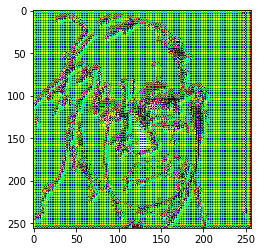

In [0]:
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [0]:
LAMBDA = 100

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)



discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
!mkdir "/content/drive/My Drive/draw_final_2"
checkpoint_dir = "/content/drive/My Drive/draw_final_2"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

mkdir: cannot create directory ‘/content/drive/My Drive/draw_final_2’: File exists


In [0]:
EPOCHS = 150
#Para el training del modelo final fueron aplicadas varias etapas de Finetunning, si es la primera vez que entrena
#son recomendables 150 epocas para obtener resultados semejantes

In [0]:
def generate_images(model, test_input, tar):

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    # Train
    for input_image, target in train_ds:
      train_step(input_image, target)

    clear_output(wait=True)
    # Test on the same image so that the progress of the model can be 
    # easily seen.
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [0]:
fit(train_dataset, EPOCHS, test_dataset)

In [0]:
!ls {checkpoint_dir}
checkpoint_dir="/content/drive/My Drive/draw_final_2"

In [0]:


checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [0]:
from tensorflow import keras
keras.models.save_model(generator,"/content/drive/My Drive/train_draw/model.h5")
#generator=keras.models.load_model("/content/drive/My Drive/train_draw/model.h5",compile=True)

## Generate using test dataset

In [0]:
# Run the trained model on the entire test dataset
import time

for inp, tar in test_dataset.take(30):
  s=time.time()
  generate_images(generator, inp, tar)
  print(time.time()-s)  
